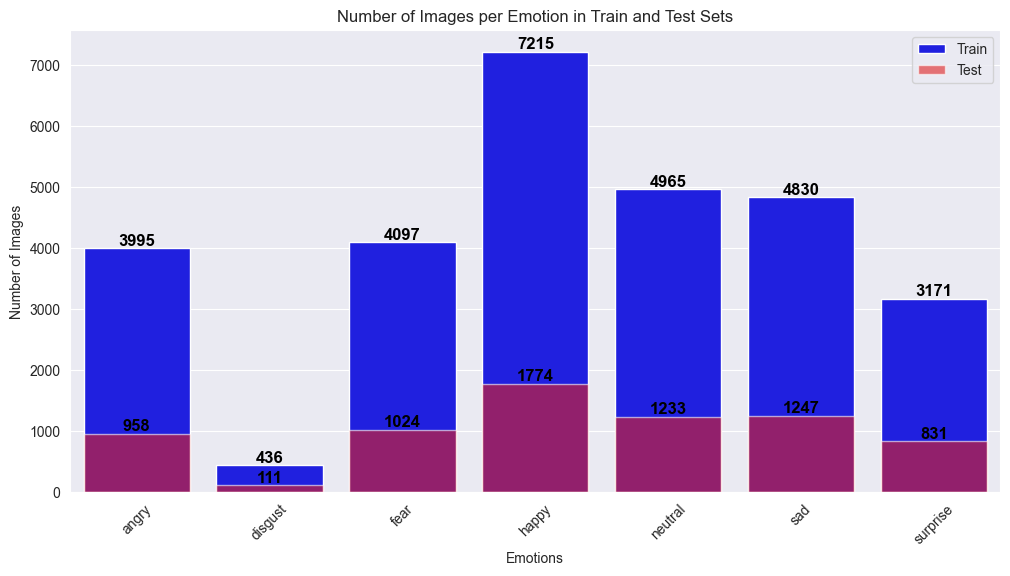

Total train images: 28709
Total test images: 7178
Total images in dataset: 35887


In [1]:
#EDA
import os
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Get emotion categories
emotions = sorted(os.listdir(train_dir))

# Count images per emotion in train and test sets
train_counts = {emotion: len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions}
test_counts = {emotion: len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions}

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
total_images = total_train + total_test

# Plot the counts
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), color="blue", label="Train")
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), color="red", alpha=0.6, label="Test")

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.xlabel("Emotions")
plt.ylabel("Number of Images")
plt.title("Number of Images per Emotion in Train and Test Sets")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Print total image counts
print(f"Total train images: {total_train}")
print(f"Total test images: {total_test}")
print(f"Total images in dataset: {total_images}")

In [3]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

# Define dataset paths
data_dir = "dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

def random_transform(image, prob=0.5):
    """Applies random scaling, shifting, and rotation with 50% probability."""
    if random.random() > prob:
        return image  # Skip transformation

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Random scaling (80% to 120%)
    scale = random.uniform(0.8, 1.2)

    # Random rotation (-10 to +10 degrees)
    angle = random.uniform(-10, 10)

    # Random shifting (-20% to +20%)
    max_shift = int(0.2 * min(h, w))
    shift_x, shift_y = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)

    # Transformation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)
    M[:, 2] += [shift_x, shift_y]

    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def random_erase(image, erase_prob=0.5, erase_size=(10, 10)):
    """Applies random erasing with given probability."""
    if random.random() > erase_prob:
        return image  # Skip erasing

    h, w = image.shape
    erase_h, erase_w = erase_size

    # Ensure erasing region fits within the image
    x, y = random.randint(0, w - erase_w), random.randint(0, h - erase_h)
    image[y:y + erase_h, x:x + erase_w] = 0  # Set erased region to black

    return image

def ten_crop(image, crop_size=(40, 40)):
    """Generates 5 crops (top-left, top-right, bottom-left, bottom-right, center) and their flipped versions."""
    h, w = image.shape
    ch, cw = crop_size
    half_ch, half_cw = ch // 2, cw // 2

    crops = [
        image[0:ch, 0:cw],  # Top-left
        image[0:ch, w-cw:w],  # Top-right
        image[h-ch:h, 0:cw],  # Bottom-left
        image[h-ch:h, w-cw:w],  # Bottom-right
        image[h//2 - half_ch:h//2 + half_ch, w//2 - half_cw:w//2 + half_cw]  # Center
    ]
    
    # Add flipped crops
    return crops + [cv2.flip(crop, 1) for crop in crops]

def preprocess_image(image_path):
    """Loads an image, applies augmentations, ten-crop, random erasing, and normalization."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48))  # Ensure consistent input size

    # Apply random transformations with 50% probability
    image = random_transform(image, prob=0.5)

    # Generate 10 cropped versions (original + flipped)
    crops = ten_crop(image, crop_size=(40, 40))

    # Apply random erasing and normalize in one step (vectorized)
    return [random_erase(crop, erase_prob=0.5) / 255.0 for crop in crops]

def preprocess_dataset(data_path, save_path):
    """Processes all images in the dataset, generating and saving 10 crops per image."""
    os.makedirs(save_path, exist_ok=True)
    
    for emotion in sorted(os.listdir(data_path)):
        emotion_dir = os.path.join(data_path, emotion)
        save_emotion_dir = os.path.join(save_path, emotion)
        os.makedirs(save_emotion_dir, exist_ok=True)

        for image_file in tqdm(os.listdir(emotion_dir), desc=f"Processing {emotion}"):
            image_path = os.path.join(emotion_dir, image_file)
            crops = preprocess_image(image_path)

            for i, crop in enumerate(crops):
                save_filename = f"{os.path.splitext(image_file)[0]}_crop{i}.png"
                cv2.imwrite(os.path.join(save_emotion_dir, save_filename), (crop * 255).astype(np.uint8))

# Preprocess train and test datasets
preprocess_dataset(train_dir, "/kaggle/working/train-preprocessed2")
preprocess_dataset(test_dir, "/kaggle/working/test-preprocessed2")

Processing surprise: 100%|██████████| 831/831 [00:08<00:00, 102.07it/s]


In [4]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

# Define dataset paths
data_dir = "dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

def random_transform(image, prob=0.5):
    """Applies random scaling, shifting, and rotation with 50% probability."""
    if random.random() > prob:
        return image  # Skip transformation

    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    
    # Random scaling (80% to 120%)
    scale = random.uniform(0.8, 1.2)

    # Random rotation (-10 to +10 degrees)
    angle = random.uniform(-10, 10)

    # Random shifting (-20% to +20%)
    max_shift = int(0.2 * min(h, w))
    shift_x, shift_y = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)

    # Transformation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)
    M[:, 2] += [shift_x, shift_y]

    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def random_erase(image, erase_prob=0.5, erase_size=(10, 10)):
    """Applies random erasing with given probability."""
    if random.random() > erase_prob:
        return image  # Skip erasing

    h, w = image.shape
    erase_h, erase_w = erase_size

    # Ensure erasing region fits within the image
    x, y = random.randint(0, w - erase_w), random.randint(0, h - erase_h)
    image[y:y + erase_h, x:x + erase_w] = 0  # Set erased region to black

    return image

def ten_crop(image, crop_size=(40, 40)):
    """Generates 5 crops (top-left, top-right, bottom-left, bottom-right, center) and their flipped versions."""
    h, w = image.shape
    ch, cw = crop_size
    half_ch, half_cw = ch // 2, cw // 2

    crops = [
        image[0:ch, 0:cw],  # Top-left
        image[0:ch, w-cw:w],  # Top-right
        image[h-ch:h, 0:cw],  # Bottom-left
        image[h-ch:h, w-cw:w],  # Bottom-right
        image[h//2 - half_ch:h//2 + half_ch, w//2 - half_cw:w//2 + half_cw]  # Center
    ]
    
    # Add flipped crops
    return crops + [cv2.flip(crop, 1) for crop in crops]

def preprocess_image(image_path):
    """Loads an image, applies augmentations, ten-crop, random erasing, and normalization."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48))  # Ensure consistent input size

    # Apply random transformations with 50% probability
    image = random_transform(image, prob=0.5)

    # Generate 10 cropped versions (original + flipped)
    crops = ten_crop(image, crop_size=(40, 40))

    # Apply random erasing and normalize in one step (vectorized)
    return [random_erase(crop, erase_prob=0.5) / 255.0 for crop in crops]

def preprocess_dataset(data_path, save_path):
    """Processes all images in the dataset, generating and saving 10 crops per image."""
    os.makedirs(save_path, exist_ok=True)
    
    for emotion in sorted(os.listdir(data_path)):
        emotion_dir = os.path.join(data_path, emotion)
        save_emotion_dir = os.path.join(save_path, emotion)
        os.makedirs(save_emotion_dir, exist_ok=True)

        for image_file in tqdm(os.listdir(emotion_dir), desc=f"Processing {emotion}"):
            image_path = os.path.join(emotion_dir, image_file)
            crops = preprocess_image(image_path)

            for i, crop in enumerate(crops):
                save_filename = f"{os.path.splitext(image_file)[0]}_crop{i}.png"
                cv2.imwrite(os.path.join(save_emotion_dir, save_filename), (crop * 255).astype(np.uint8))

# Preprocess train and test datasets
preprocess_dataset(train_dir, "/dataset/train-preprocessed2")
preprocess_dataset(test_dir, "/dataset/test-preprocessed2")

Processing surprise: 100%|██████████| 831/831 [00:03<00:00, 243.30it/s]


In [6]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm

# Define dataset paths
data_dir = "dataset"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")


def random_transform(image, prob=0.5):
    """Applies random scaling, shifting, and rotation with 50% probability."""
    if random.random() > prob:
        return image  # Skip transformation

    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Random scaling (80% to 120%)
    scale = random.uniform(0.8, 1.2)

    # Random rotation (-10 to +10 degrees)
    angle = random.uniform(-10, 10)

    # Random shifting (-20% to +20%)
    max_shift = int(0.2 * min(h, w))
    shift_x, shift_y = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)

    # Transformation matrix
    M = cv2.getRotationMatrix2D(center, angle, scale)
    M[:, 2] += [shift_x, shift_y]

    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)


def random_erase(image, erase_prob=0.5, erase_size=(10, 10)):
    """Applies random erasing with given probability."""
    if random.random() > erase_prob:
        return image  # Skip erasing

    h, w = image.shape
    erase_h, erase_w = erase_size

    # Ensure erasing region fits within the image
    x, y = random.randint(0, w - erase_w), random.randint(0, h - erase_h)
    image[y:y + erase_h, x:x + erase_w] = 0  # Set erased region to black

    return image


def ten_crop(image, crop_size=(40, 40)):
    """Generates 5 crops (top-left, top-right, bottom-left, bottom-right, center) and their flipped versions."""
    h, w = image.shape
    ch, cw = crop_size
    half_ch, half_cw = ch // 2, cw // 2

    crops = [
        image[0:ch, 0:cw],  # Top-left
        image[0:ch, w - cw:w],  # Top-right
        image[h - ch:h, 0:cw],  # Bottom-left
        image[h - ch:h, w - cw:w],  # Bottom-right
        image[h // 2 - half_ch:h // 2 + half_ch, w // 2 - half_cw:w // 2 + half_cw]  # Center
    ]

    # Add flipped crops
    return crops + [cv2.flip(crop, 1) for crop in crops]


def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48))  # Ensure consistent input size

    # Apply random transformations with 50% probability
    image = random_transform(image, prob=0.5)

    # Generate 10 cropped versions (original + flipped)
    crops = ten_crop(image, crop_size=(40, 40))

    # Apply random erasing and normalize in one step (vectorized)
    return [random_erase(crop, erase_prob=0.5) / 255.0 for crop in crops]


def preprocess_dataset(data_path, save_path):
    """Processes all images in the dataset, generating and saving 10 crops per image."""
    os.makedirs(save_path, exist_ok=True)

    for emotion in sorted(os.listdir(data_path)):
        emotion_dir = os.path.join(data_path, emotion)
        save_emotion_dir = os.path.join(save_path, emotion)
        os.makedirs(save_emotion_dir, exist_ok=True)

        for image_file in tqdm(os.listdir(emotion_dir), desc=f"Processing {emotion}"):
            image_path = os.path.join(emotion_dir, image_file)
            crops = preprocess_image(image_path)

            for i, crop in enumerate(crops):
                save_filename = f"{os.path.splitext(image_file)[0]}_crop{i}.png"
                cv2.imwrite(os.path.join(save_emotion_dir, save_filename), (crop * 255).astype(np.uint8))


# Preprocess train and test datasets
preprocess_dataset(train_dir, "dataset/train-preprocessed2")
preprocess_dataset(test_dir, "dataset/test-preprocessed2")

Processing surprise: 100%|██████████| 831/831 [00:09<00:00, 87.28it/s] 


In [7]:
import shutil

shutil.make_archive("dataset/preprocessed_data-train2", 'zip', "dataset/train-preprocessed2")

shutil.make_archive("dataset/preprocessed_data-test2", 'zip', "dataset/test-preprocessed2")

'D:\\depression\\dataset\\preprocessed_data-test2.zip'

In [4]:
# Training using best Optimizer: SGD Nesterov
import tensorflow as tf
from keras import layers, models, optimizers, mixed_precision
from keras.api.regularizers import l2
import os

# Enable mixed precision training (gradient scaling)
mixed_precision.set_global_policy('mixed_float16')

# Data Paths
data_dir = "dataset"
train_dir = os.path.join(data_dir, "train-preprocessed2")
test_dir = os.path.join(data_dir, "test-preprocessed2")

# Variables for model saving/resuming
saved_model_path = "dataset/latest_vggnet_model.keras"  # Path to save the model
last_saved_epoch = 0  # Update this when resuming training (1-19, e.g., 15, 30, ...)

# Load dataset with train-validation split
def load_data(directory, batch_size=64, img_size=(40, 40), val_split=0.1):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        label_mode='int',
        validation_split=val_split,
        subset="training",
        seed=123
    )
    
    val_dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        color_mode='grayscale',
        batch_size=batch_size,
        label_mode='int',
        validation_split=val_split,
        subset="validation",
        seed=123
    )
    
    return dataset, val_dataset

# Load train and validation sets
train_dataset, val_dataset = load_data(train_dir)

# Load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(40, 40),
    color_mode='grayscale',
    batch_size=64,
    label_mode='int'
)

# Training Parameters
initial_lr = 0.01
momentum = 0.9
batch_size = 64
weight_decay = 0.0001  # L2 Regularization factor
total_epochs = 300
num_training_samples = 258381 

# Correct decay_steps calculation
decay_steps = (num_training_samples // batch_size) * total_epochs

# Learning rate schedule for decaying LR
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr, 
    decay_steps=decay_steps, 
    decay_rate=0.9, 
    staircase=True
)

# Optimizer with decaying LR (Weight decay applied via kernel_regularizer)
optimizer_decay = optimizers.SGD(learning_rate=lr_schedule, momentum=momentum, nesterov=True)

# VGGNet Model Definition with Weight Decay
def build_vggnet(input_shape=(40, 40, 1), num_classes=7):
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Explicit Input layer
        layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Dense(128, kernel_regularizer=l2(weight_decay)),
        layers.ReLU(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])

    return model

# Load existing model if resuming, otherwise create a new model
if os.path.exists(saved_model_path) and last_saved_epoch > 0:
    print(f"Resuming training from epoch {last_saved_epoch + 1}...")
    model = tf.keras.models.load_model(saved_model_path)
else:
    print("Starting training from scratch...")
    model = build_vggnet()

# Compile model
model.compile(optimizer=optimizer_decay, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback to save latest model every 15 epochs
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    saved_model_path,
    save_weights_only=False,  # Save entire model (architecture + optimizer state)
    save_best_only=False,  # Always overwrite the latest checkpoint
    save_freq=15 * (num_training_samples // batch_size),  # Save every 15 epochs
    verbose=1
)

# Train with Decaying LR (continuing from last saved epoch)
history_decay = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    initial_epoch=last_saved_epoch,  # Resume training from last saved checkpoint
    callbacks=[checkpoint_callback]
)

# Evaluate Model (Decaying LR)
test_loss_decay, test_acc_decay = model.evaluate(test_dataset)
print(f"Test Accuracy (Decaying LR): {test_acc_decay * 100:.2f}%")

# Final Model Save
model.save(saved_model_path)
print(f"Final model saved at {saved_model_path}")

# Test accuracy: 54.68%
# Val_accuracy of the last Epoch: 74.37%
# Please refer to the word document for more details 改为使用gpu训练

Found 287090 files belonging to 7 classes.
Using 258381 files for training.
Found 287090 files belonging to 7 classes.
Using 28709 files for validation.
Found 71780 files belonging to 7 classes.
Starting training from scratch...
Epoch 1/300
  67/4038 ━━━━━━━━━━━━━━━━━━━━ 4:24:02 4s/step - accuracy: 0.1814 - loss: 2.7473

KeyboardInterrupt: 